# Fig 4: Activation and PPIs/Dimerization

- effector domain alterations and activation
- PPI changes and activation
- obligate dimer analysis

In [1]:
import numpy as np
import matplotlib as mpl
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import seaborn as sns
import sys

#from statannotations.Annotator import Annotator
from scipy.stats import wilcoxon

# import utils
sys.path.append("../")
sys.path.append("../data_loading")

import plotting
from plotting import (mimic_r_boxplot,
                      violinplot_reflected,
                      y2h_ppi_per_tf_gene_plot,
                      y1h_pdi_per_tf_gene_plot,
                      m1h_activation_per_tf_gene_plot,
                      annotate_pval)

from data_loading import (load_y2h_isoform_data, 
                          load_m1h_activation_data, 
                          load_ppi_partner_categories, 
                          load_annotated_TFiso1_collection,
                          load_human_tf_db,
                          load_y1h_pdi_data,
                          load_tf_families,
                          DIMERIZING_TF_FAMILIES,
                          load_ref_vs_alt_isoforms_table,
                          load_pfam_domains_horfeome,
                          load_full_y2h_data_including_controls)

from data_loading.isoform_pairwise_metrics import _add_PPI_columns

/PHShome/kz659/.conda/envs/tfisos/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
PAPER_PRESET = {"style": "ticks", "font": ["Helvetica", "DejaVu Sans"], "context": "paper", 
                "rc": {"font.size":7,"axes.titlesize":7,
                     "pdf.fonttype": 42, 
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [4]:
np.random.seed(2023)

## 1. load TFs, assay data (Y2H, M1H), Pfam domains, and PPI partner categories/cofactors

In [5]:
tfs = load_annotated_TFiso1_collection()
pairs = load_ref_vs_alt_isoforms_table()

# RORC-1 alt iso is causing an error - filter out here - there's no data for it?
pairs = pairs[pairs["clone_acc_alt"] != "RORC|1/6|05F11"]

pairs['ref_iso'] = pairs['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
pairs['alt_iso'] = pairs['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
pairs['f_disorder_difference'] = pairs.apply(lambda x: tfs[x['gene_symbol']].disordered_fraction_of_different_regions(x['ref_iso'], x['alt_iso']), axis=1)

reading from cache
generating reference vs alternative table
reading from cache
reading from cache


100%|██████████| 246/246 [01:15<00:00,  3.26it/s]


/data/bulyk/kaia/projects/repos/TF_isoforms_paper/data/external/go-basic.obo: fmt(1.2) rel(2023-07-27) 46,356 Terms; optional_attrs(relationship)
reading from cache
/data/bulyk/kaia/projects/repos/TF_isoforms_paper/data/external/go-basic.obo: fmt(1.2) rel(2023-07-27) 46,356 Terms; optional_attrs(relationship)
reading from cache


In [6]:
y2h = load_y2h_isoform_data()
m1h = load_m1h_activation_data()
m1h['mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)
cats = load_ppi_partner_categories()

reading from cache
reading from cache


In [7]:
df = pd.read_excel('../../data/external/Geiger-et-al_MCP_2012_Supplementary-Table-2.xlsx',
                   skiprows=1)
hek_avrg = df[['iBAQ HEK293_1', 'iBAQ HEK293_2', 'iBAQ HEK293_3']].mean(axis=1)
print((hek_avrg > 0).sum(), 'proteins expressed in HEK293 proteome')
hek_expressed_genes = set(df.loc[(hek_avrg > 0) & df['Gene Names'].notnull(),
       'Gene Names'].str.split(';').explode().values)
all_partners = set(y2h['db_gene_symbol'].unique())
print('of {} PPI partners, {} are expressed in HEK293 cells'.format(len(all_partners), 
      len(all_partners.intersection(hek_expressed_genes))))

8543 proteins expressed in HEK293 proteome
of 508 PPI partners, 256 are expressed in HEK293 cells


In [8]:
# now add Pfam AD/RDs
pfam = pd.read_csv('../../data/external/Pfam-A.clans.tsv',
                   sep='\t',
                   names=['pfam_accession', 'clan', 'clan_name', 'short_name', 'name'])

In [9]:
cof = pd.read_csv('../../data/external/AnimalTFDB3_Homo_sapiens_TF_cofactors.txt',
                 sep='\t')
if cof['Symbol'].duplicated().any():
    raise UserWarning('unexpected duplicates')

## 2. categorize effector domain changes between alt/ref iso

In [10]:
dom = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])

# add activation or repression annotation from effector domain studies
effector_domain_type = {}
for tf in tfs.values():
    for d in tf.cloned_reference_isoform.aa_seq_features:
        if d.category == 'effector_domain':
            effector_domain_type[d.accession] = d.name
dom['type'] = dom['accession'].map(effector_domain_type)

In [11]:
def fraction_of_effector_domains_removed(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'].isin(effector_type)), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds[['deletion', 'frameshift']].sum().sum() / ds['length'].sum()


def insertion_in_effector_domains(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'].isin(effector_type)), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['insertion'].sum()

def domain_length(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'].isin(effector_type)), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['length'].sum()


for effector_type, effector_type_name in zip([['AD'], ['RD'], ['Bif'], ['AD', 'RD', 'Bif']], ['AD', 'RD', 'Bif', 'all']):
    pairs['fraction_of_{}_domains_removed'.format(effector_type_name)] = pairs.apply(fraction_of_effector_domains_removed, effector_type=effector_type, axis=1)
    pairs['insertion_in_{}_domains'.format(effector_type_name)] = pairs.apply(insertion_in_effector_domains, effector_type=effector_type, axis=1)
    pairs['length_of_{}_domains'.format(effector_type_name)] = pairs.apply(domain_length, effector_type=effector_type, axis=1)

## 3. plot number of annotated domains (of various types) across isoforms

Text(0.5, 0, 'Effector domains in reference isoform')

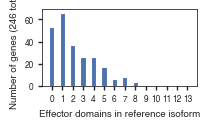

In [12]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain':
            c += 1
    return c

n_effector = [count_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1, figsize=(2, 1))
ax.hist(n_effector,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')

Text(0.5, 1.0, 'Soto et al. data')

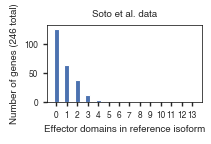

In [13]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_Soto_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain' and d.accession.startswith('Soto'):
            c += 1
    return c

n_effector_soto = [count_Soto_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1, figsize=(2, 1))
ax.hist(n_effector_soto,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')
ax.set_title('Soto et al. data')

Text(0.5, 1.0, 'Data from Bintu lab papers')

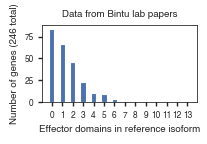

In [14]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_Bintu_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain' and not d.accession.startswith('Soto'):
            c += 1
    return c

n_effector_bintu = [count_Bintu_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1, figsize=(2, 1))
ax.hist(n_effector_bintu,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')
ax.set_title('Data from Bintu lab papers')

In [15]:
counter = {'Soto': {'AD': 0, 'RD': 0, 'Bif': 0},
           'Tycko': {'AD': 0, 'RD': 0},
           'DelRosso': {'AD': 0, 'RD': 0}}
for tf in tfs.values():
    has_effector = False
    for domain in tf.cloned_reference_isoform.aa_seq_features:
        if domain.category == 'effector_domain':
            counter[domain.accession.split('_')[0]][domain.name] += 1
counter

{'Soto': {'AD': 126, 'RD': 71, 'Bif': 4},
 'Tycko': {'AD': 3, 'RD': 36},
 'DelRosso': {'AD': 33, 'RD': 291}}

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


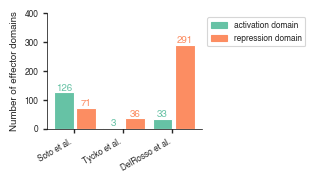

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
ax.bar(x=[0.1, 1.0, 2.1, 3.0, 4.1, 5.0],
       height=[counter[x][y] for x in counter.keys() for y in ['AD', 'RD']],
       color=[sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]] * 3)
ax.set_xticks([0.5, 2.5, 4.5])
ax.set_xticklabels(['Soto et al.', 'Tycko et al.', 'DelRosso et al.'], rotation=30, ha="right", va="top")
ax.set_ylabel('Number of effector domains')

# annotate
rects = ax.patches
labels = [counter[x][y] for x in counter.keys() for y in ['AD', 'RD']]
colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]] * 3
for rect, label, color in zip(rects, labels, colors):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom", color=color)

colors = {"activation domain": sns.color_palette("Set2")[0], 
          "repression domain": sns.color_palette("Set2")[1]}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0), 1, 1, color=colors[label]) for label in labels]
plt.legend(handles, labels, loc=2, bbox_to_anchor=(1.01, 1))

plt.ylim((0, 400))

for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)

fig.savefig("../../figures/fig4/annotated_effector_domain_count.pdf", dpi="figure", bbox_inches="tight")

## 4. summary plot looking at presence of activ/repr domains and activity

In [17]:
# define activity above baseline as >= 1 (absolute value)
m1h['gte_2_fold'] = (m1h['mean'].abs() >= 1)
m1h['gte_above'] = (m1h['mean'] >= 1)
m1h['gte_below'] = (m1h['mean'] <= -1)
m1h.head()

,gene_symbol,clone_acc,M1H_rep1,M1H_rep2,M1H_rep3,mean,gte_2_fold,gte_above,gte_below
360,AEBP2,AEBP2|2/3|05F03,0.241019,0.189211,0.473661,0.301297,False,False,False
359,AEBP2,AEBP2|3/3|05E07,-0.276303,-0.305477,-0.121186,-0.234322,False,False,False
0,ARNT2,ARNT2|1/6|08C12,4.498733,4.501519,4.297244,4.432498,True,True,False
1,ARNT2,ARNT2|2/6|09E01,2.407721,2.407411,2.197963,2.337698,True,True,False
3,ARNTL2,ARNTL2|2/5|12C06,0.398027,0.391809,0.299461,0.363099,False,False,False


In [18]:
ads = []
rds = []
bifs = []

for i, row in m1h.iterrows():
    gene = row.gene_symbol
    iso = row.clone_acc
    try:
        tf_iso = tfs[gene][iso]
    except KeyError:
        print("missing tf %s or iso %s" % (gene, iso))
        ads.append(np.nan)
        rds.append(np.nan)
        bifs.append(np.nan)
        continue
    
    has_ad = False
    has_rd = False
    has_bif = False
    for domain in tf_iso.aa_seq_features:
        if domain.category == 'effector_domain':
            if domain.name == "AD":
                has_ad = True
            if domain.name == "RD":
                has_rd = True
            if domain.name == "Bif":
                has_bif = True
    
    ads.append(has_ad)
    rds.append(has_rd)
    bifs.append(has_bif)

missing tf DLX6 or iso DLX6|2/2|05G01
missing tf ELK3 or iso ELK3|1/2|11E09
missing tf FOXD4L1 or iso FOXD4L1|1/2|06E05
missing tf FOXD4L3 or iso FOXD4L3|1/2|04G01
missing tf FOXO3 or iso FOXO3|2/2|08E03
missing tf GATA1 or iso GATA1|1/2|08A02
missing tf HEY2 or iso HEY2|2/2|05C07
missing tf HOMEZ or iso HOMEZ|2/3|06G05
missing tf HOXA9 or iso HOXA9|1/3|09G01
missing tf KLF4 or iso KLF4|1/3|01H05
missing tf KLF6 or iso KLF6|1/2|11D07
missing tf LCOR or iso LCOR|2/2|12B05
missing tf NANOG or iso NANOG|1/2|01C08
missing tf NANOG or iso NANOG|2/2|01H08
missing tf NEUROD1 or iso NEUROD1|1/2|11B09
missing tf NFAT5 or iso NFAT5|1/2|02F01
missing tf PCGF6 or iso PCGF6|1/2|11A10
missing tf PCGF6 or iso PCGF6|2/2|11B07
missing tf POU2F2 or iso POU2F2|4/4|11A08
missing tf POU5F1 or iso POU5F1|1/2|11H07
missing tf RARA or iso RARA|1/2|11B12
missing tf REL or iso REL|1/2|12D03
missing tf RXRB or iso RXRB|1/2|01G03
missing tf SALL3 or iso SALL3|1/2|01B09
missing tf SOX10 or iso SOX10|1/2|03H02
miss

In [19]:
m1h['has_ad'] = ads
m1h['has_rd'] = rds
m1h['has_bif'] = bifs

# filter out the above isos that got removed from clone collection post-hoc
m1h = m1h[~pd.isnull(m1h['has_ad'])]
len(m1h)

580

In [20]:
len(m1h.gene_symbol.unique())

224

In [21]:
def cat_dom(row):
    if row.has_ad == True and row.has_rd == False and row.has_bif == False:
        return "activation domain"
    elif row.has_ad == False and row.has_rd == True and row.has_bif == False:
        return "repression domain"
    elif row.has_ad == False and row.has_rd == False and row.has_bif == True:
        return "bifunctional domain"
    elif row.has_ad == False and row.has_rd == False and row.has_bif == False:
        return "no annotated domains"
    else:
        return "combination of domains"

m1h["cat_dom"] = m1h.apply(cat_dom, axis=1)
m1h.cat_dom.value_counts()

cat_dom
no annotated domains      201
repression domain         192
combination of domains    135
activation domain          50
bifunctional domain         2
Name: count, dtype: int64

In [22]:
def cat_gte(row):
    if row.gte_above:
        return "above baseline"
    elif row.gte_below:
        return "below baseline"
    else:
        return "NA"
    
m1h["cat_gte"] = m1h.apply(cat_gte, axis=1)
m1h.cat_gte.value_counts()

cat_gte
above baseline    295
NA                239
below baseline     46
Name: count, dtype: int64

In [23]:
m1h_filt = m1h[(m1h["cat_gte"] != "NA") & (m1h["cat_dom"].isin(["activation domain", "repression domain"]))]
m1h_filt = pd.pivot_table(m1h_filt, index="cat_dom", columns="cat_gte", values='clone_acc', aggfunc='count')
print(m1h_filt.sum())
m1h_filt = m1h_filt/m1h_filt.sum()
m1h_filt

cat_gte
above baseline    112
below baseline     23
dtype: int64


cat_gte,above baseline,below baseline
cat_dom,,
activation domain,0.3125,0.043478
repression domain,0.6875,0.956522


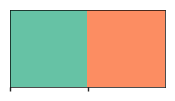

In [24]:
palette = {"activation domain": sns.color_palette("Set2")[0],
           "repression domain": sns.color_palette("Set2")[1]}
sns.palplot(palette.values())

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


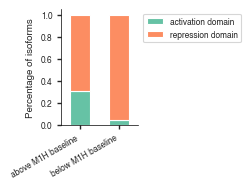

In [25]:
ax = m1h_filt.T.plot.bar(stacked=True, color=palette.values(), figsize=(1, 1.5))

ax.set_ylabel("Percentage of isoforms")
ax.set_xlabel("")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))
ax.set_xticklabels(["above M1H baseline", "below M1H baseline"], ha="right", va="top", rotation=30)

for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)

plt.savefig('../../figures/fig4/m1h_baseline_doms.pdf',
            bbox_inches='tight')

### how many TFs have isos that are both strong activators and strong repressors?

In [26]:
m1h_stack = pd.pivot_table(m1h, values="clone_acc", index="gene_symbol", columns="cat_gte", aggfunc='count').reset_index()
m1h_stack.fillna(0, inplace=True)
m1h_stack[(m1h_stack["above baseline"] > 0) & (m1h_stack["below baseline"] > 0)]

cat_gte,gene_symbol,NA,above baseline,below baseline
38,FOXP3,2.0,2.0,1.0
62,MAX,0.0,1.0,4.0
63,MAZ,0.0,1.0,1.0
202,ZNF544,1.0,2.0,3.0


## 5. summary plot looking at gain/loss of domains and activity

In [27]:
pairs['m1h_gte_2_fold_at_least_one_iso_per_gene'] = pairs['gene_symbol'].map(m1h.groupby('gene_symbol')
                                                                             ['gte_2_fold']
                                                                             .any())
pairs['abs_activation_fold_change_log2'] = pairs['activation_fold_change_log2'].abs()

In [28]:
# create a color map of domain length
# sum up lengths of all domains (plot only includes examples w 1 type of domain)
pairs['length_of_all_domains'].fillna(0, inplace=True)
t_dom_length = pairs.loc[:,'length_of_all_domains'].values
t_dom_length = t_dom_length[t_dom_length > 0]

# using min and max makes colors too hard too read - cut off
cmap = sns.color_palette("flare", as_cmap=True)
norm = plt.Normalize(25, 250)
palette_dom_length = {value: cmap(norm(value)) for value in t_dom_length}

def re_color(row, palette):
    if row['length_of_all_domains'] == 0:
        color = sns.color_palette("flare")[0]
    else:
        color = palette[row['length_of_all_domains']]
    return color

pairs["color_dom_length"] = pairs.apply(re_color, axis=1, palette=palette_dom_length)

In [29]:
df = pairs.copy()
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


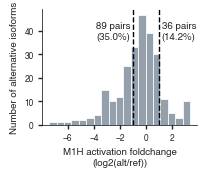

In [30]:
fig = plt.figure(figsize=(2, 1.5))
ax = sns.histplot(data=df, x="activation_fold_change_log2", color="slategrey")
ax.set_xlabel("M1H activation foldchange\n(log2(alt/ref))")
ax.set_ylabel("Number of alternative isoforms")

ax.axvline(x=-1, linestyle="dashed", color="black", linewidth=1)
ax.axvline(x=1, linestyle="dashed", color="black", linewidth=1)

# annotate
n_less_neg1 = len(df[df["activation_fold_change_log2"] <= -1])
n_greater_1 = len(df[df["activation_fold_change_log2"] >= 1])

ax.text(-1.2, 40, "%s pairs\n(%s%%)" % (n_less_neg1, np.round(n_less_neg1/len(df)*100, 1)), ha="right", va="center")
ax.text(1.2, 40, "%s pairs\n(%s%%)" % (n_greater_1, np.round(n_greater_1/len(df)*100, 1)), ha="left", va="center")

for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)

fig.savefig("../../figures/fig4/m1h_alt_ref_dist.pdf", dpi="figure", bbox_inches="tight")

In [31]:
print("NUM ALT ISOS WITH AT LEAST 2-FOLD CHANGE COMPARED TO REF: %s" % (n_less_neg1 + n_greater_1))
print("PERCENT ALT ISOS WITH AT LEAST 2-FOLD CHANGE COMPARED TO REF: %s" % ((n_less_neg1 + n_greater_1)/len(df)*100))

NUM ALT ISOS WITH AT LEAST 2-FOLD CHANGE COMPARED TO REF: 125
PERCENT ALT ISOS WITH AT LEAST 2-FOLD CHANGE COMPARED TO REF: 49.21259842519685


found: 1.0, -3.1682185672413987
3.1221240201041938
found: 1.0, 3.1221240201041938
found: 0.345565749235474, -7.433645243118278
found: 0.03527884010424481, -1.099521718454923
found: 0.007805116736277651, -2.342060295980464


/PHShome/kz659/.conda/envs/tfisos/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 18.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


found: 0.02411755795203807, -1.373816506015626
found: 1.1102230246251565e-16, -4.185867921507783


/PHShome/kz659/.conda/envs/tfisos/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 22.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/tfisos/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 25.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


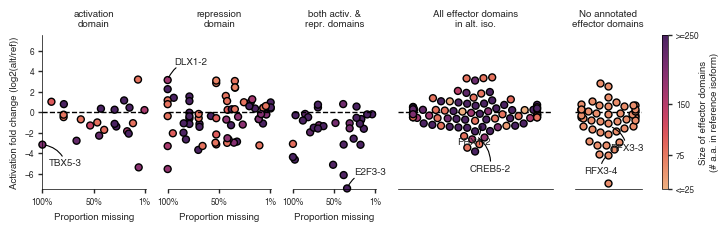

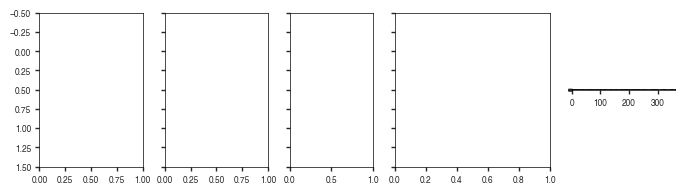

In [32]:
# combining full + partial loss since we only have 1 full loss activ. domain
palette = palette_dom_length
hue = 'length_of_all_domains'
color = 'color_dom_length'
t = t_dom_length

gs_kw = dict(width_ratios=[1, 1, 0.8, 1.5, 1])

fig, axs = plt.subplots(1, 5, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=8.2, h=2)

point_size = 5

######### activation domain (full and partial) #########
tot_n_part_loss_activ = df.loc[(df['fraction_of_AD_domains_removed'] > 0) 
                             & (df['fraction_of_RD_domains_removed'].isnull() | 
                               (df['fraction_of_RD_domains_removed'] == 0))
                             & (df['fraction_of_Bif_domains_removed'].isnull() | 
                               (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[0].set_title('activation\ndomain')
axs[0].scatter(tot_n_part_loss_activ.loc[:, 'fraction_of_AD_domains_removed'].values,
               tot_n_part_loss_activ.loc[:, 'activation_fold_change_log2'].values,
               alpha=1,
               s=point_size**2,
               c=tot_n_part_loss_activ.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
               clip_on=False)
axs[0].set_xticks([])
axs[0].set_xlabel('Proportion missing')
axs[0].set_xlim(1, 0)
axs[0].set_xticks([1, 0.5, 0.01])
axs[0].set_xticklabels([f'{x:.0%}' for x in axs[0].get_xticks()])

tbx5_y = df.loc[(df["clone_acc_alt"] == "TBX5|3/3|08H01"), 'activation_fold_change_log2'].values[0]
for point in axs[0].collections:
    for x, y in point.get_offsets():
        if np.isclose(tbx5_y, y):
            print("found: %s, %s" % (x, y))
            axs[0].annotate("TBX5-3", xy=(x, y), xytext=(5, -10), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
                                              color='black'), 
                            ha="left", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

######### repression domain (full and partial) #########
tot_n_part_loss_repr = df.loc[(df['fraction_of_RD_domains_removed'] > 0)
                            & (df['fraction_of_AD_domains_removed'].isnull() | 
                              (df['fraction_of_AD_domains_removed'] == 0))
                            & (df['fraction_of_Bif_domains_removed'].isnull() | 
                              (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[1].set_title('repression\ndomain')
axs[1].scatter(tot_n_part_loss_repr.loc[:, 'fraction_of_RD_domains_removed'].values,
               tot_n_part_loss_repr.loc[:, 'activation_fold_change_log2'].values,
               alpha=1,
               s=point_size**2,
               c=tot_n_part_loss_repr.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
               clip_on=False)
axs[1].set_xticks([])
axs[1].set_xlabel('Proportion missing')
axs[1].set_xlim(1, 0)
axs[1].set_xticks([1, 0.5, 0.01])
axs[1].set_xticklabels([f'{x:.0%}' for x in axs[1].get_xticks()])

dlx1_y = df.loc[(df["clone_acc_alt"] == "DLX1|2/2|07E09"), 'activation_fold_change_log2'].values[0]
print(dlx1_y)
for point in axs[1].collections:
    for x, y in point.get_offsets():
        if np.isclose(dlx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[1].annotate("DLX1-2", xy=(x, y), xytext=(5, 10), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
                                              color='black'), 
                            ha="left", va="bottom", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

######### both activ/repression domain OR bif (full and partial) #########
tot_n_part_loss_both = df.loc[((df['fraction_of_AD_domains_removed'] > 0) &
                              (df['fraction_of_RD_domains_removed'] > 0)) |
                              (df['fraction_of_Bif_domains_removed'] > 0), :]
axs[2].set_title('both activ. &\nrepr. domains')
axs[2].scatter(tot_n_part_loss_both.loc[:, 'fraction_of_all_domains_removed'].values,
               tot_n_part_loss_both.loc[:, 'activation_fold_change_log2'].values,
               alpha=1,
               s=point_size**2,
               c=tot_n_part_loss_both.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
               clip_on=False)
axs[2].set_xticks([])
axs[2].set_xlabel('Proportion missing')
axs[2].set_xlim(1, 0)
axs[2].set_xticks([1, 0.5, 0.01])
axs[2].set_xticklabels([f'{x:.0%}' for x in axs[2].get_xticks()])

e2f3_y = df.loc[(df["clone_acc_alt"] == "E2F3|3/4|10B08"), 'activation_fold_change_log2'].values[0]
for point in axs[2].collections:
    for x, y in point.get_offsets():
        if np.isclose(e2f3_y, y):
            print("found: %s, %s" % (x, y))
            axs[2].annotate("E2F3-3", xy=(x, y), xytext=(5, 15), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
                                              color='black'), 
                            ha="left", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))



######### everything retained #########
all_retained = df.loc[((df['fraction_of_AD_domains_removed'] == 0) |
                       (df['fraction_of_RD_domains_removed'] == 0) |
                       (df['fraction_of_Bif_domains_removed'] == 0))
                     & (df['fraction_of_AD_domains_removed'].isnull() | 
                        (df['fraction_of_AD_domains_removed'] == 0)) 
                     & (df['fraction_of_RD_domains_removed'].isnull() | 
                        (df['fraction_of_RD_domains_removed'] == 0)) 
                     & (df['fraction_of_Bif_domains_removed'].isnull() | 
                        (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[3].set_title('All effector domains\nin alt. iso.')
sns.swarmplot(data=all_retained,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
              clip_on=False,
              ax=axs[3],
              linewidth=1,
              edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[3].set_xticks([])
axs[3].set_xlabel('')
axs[3].get_legend().remove()

# annotate pbx1 and rfx3
pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
creb5_y = df.loc[(df["clone_acc_alt"] == "CREB5|2/3|08A12"), 'activation_fold_change_log2'].values[0]
for point in axs[3].collections:
    for x, y in point.get_offsets():
        if np.isclose(pbx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[3].annotate("PBX1-2", xy=(x, y), xytext=(-5, -10), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
                                              color='black'), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(creb5_y, y):
            print("found: %s, %s" % (x, y))
            axs[3].annotate("CREB5-2", xy=(x, y), xytext=(10, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
                                              color='black'), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# missing stuff
incl = pd.concat([tot_n_part_loss_activ, 
                  tot_n_part_loss_repr, 
                  tot_n_part_loss_both, 
                  all_retained])

######### no annotated domains #########
no_annot = df.loc[(~df.index.isin(incl.index.values)) & (pd.isnull(df["fraction_of_AD_domains_removed"])) &
                  (pd.isnull(df["fraction_of_RD_domains_removed"])) & 
                  (pd.isnull(df["fraction_of_Bif_domains_removed"]))]
axs[4].set_title('No annotated\neffector domains')
sns.swarmplot(data=no_annot,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[4],
              linewidth=1,
               edgecolor="black",
              alpha=1,
              color=sns.color_palette("flare")[0])
axs[4].set_xticks([])
axs[4].set_xlabel('')

rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
for point in axs[4].collections:
    for x, y in point.get_offsets():
        if np.isclose(rfx3_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("RFX3-3", xy=(x, y), xytext=(0, -12), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
                                              color='black'), 
                            ha="left", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx4_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("RFX3-4", xy=(x, y), xytext=(-5, -8), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.3",
                                              color='black'), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))


# add colorbar
# mirror figure
fig2, axs2 = plt.subplots(1, 5, sharey=True, gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.2, h=2)
map1 = axs2[4].imshow(np.stack([t, t]), cmap="flare", vmin=25, vmax=250)
cbar = fig.colorbar(map1, ax=axs[4], aspect=30, pad=0.2)
cbar.set_ticks([25, 75, 150, 250])
cbar.set_ticklabels(["<=25", "75", "150", ">=250"])
cbar.set_label("Size of effector domains\n(# a.a. in reference isoform)", labelpad=0)


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed', zorder=1)
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.set_ylabel("")
axs[0].set_ylabel("Activation fold change (log2(alt/ref))")
fig.savefig('../../figures/fig4/activation_vs_domain_removal_colored_by_dom_length.collapsed.pdf', bbox_inches='tight')

In [33]:
## calculate p-value using wilcoxon
def paired_pval(x, y):
    
    # make sure x, y are filtered for nan while maintaining pair relationship
    x_filt = []
    y_filt = []
    for x_, y_ in zip(x, y):
        if pd.isnull(x_) or pd.isnull(y_):
            continue
        else:
            x_filt.append(x_)
            y_filt.append(y_)

    try:
        stat, p = wilcoxon(x_filt, y_filt)
        return p
    except:
        return np.nan

In [34]:
x = tot_n_part_loss_activ.activation_ref.values
y = tot_n_part_loss_activ.activation_alt.values
print("PAIRED WILCOXON P-VALUE COMPARING M1H REF V ALT FOR ALTS THAT LOSE ANNOTATED ACTIV DOMAIN: %s" % paired_pval(x, y))

PAIRED WILCOXON P-VALUE COMPARING M1H REF V ALT FOR ALTS THAT LOSE ANNOTATED ACTIV DOMAIN: 0.02332472801208496


## 6. pie chart of PPI categories

In [35]:
len(cats)

928

In [36]:
len(cats.gene_symbol_partner.unique())

928

In [37]:
cats.category.value_counts()

category
other        377
TF           219
signaling    214
cofactor     118
Name: count, dtype: int64

In [38]:
cats[(~pd.isnull(cats["cofactor_type"])) & (cats["cofactor_type"] != "unknown")]

,gene_symbol_partner,category,cofactor_type
9,LMO2,cofactor,coactivator
29,SUFU,cofactor,corepressor
33,CTBP1,cofactor,both
35,ARRB1,cofactor,coactivator
47,RUNX1T1,cofactor,corepressor
80,KDM1A,cofactor,coactivator
87,VGLL1,cofactor,coactivator
93,DAXX,cofactor,both
103,PAWR,cofactor,corepressor
108,CTBP2,cofactor,both


In [39]:
y2h_nonan = y2h[~pd.isnull(y2h["Y2H_result"])]
print("# of unique PPI partners found to interact w/ at least 1 TF iso")
len(y2h_nonan.db_gene_symbol.unique())

# of unique PPI partners found to interact w/ at least 1 TF iso


508

In [40]:
y2h_true = y2h_nonan[y2h_nonan["Y2H_result"]][["ad_gene_symbol", "db_gene_symbol"]].drop_duplicates()
print("# of total True gene-gene PPIs profiled")
len(y2h_true)

# of total True gene-gene PPIs profiled


936

In [41]:
print("# of unique TF isoforms found to have at least 1 PPI")
len(y2h_nonan.ad_clone_acc.unique())

# of unique TF isoforms found to have at least 1 PPI


170

In [42]:
print("# of unique TF genes found to have at least 1 PPI")
len(y2h_nonan.ad_gene_symbol.unique())

# of unique TF genes found to have at least 1 PPI


64

In [43]:
ggi = y2h_nonan[["ad_gene_symbol", "db_gene_symbol"]].drop_duplicates()
ggi

,ad_gene_symbol,db_gene_symbol
0,ATF2,ATF2
4,ATF2,JDP2
39,ATF2,FOSL2
73,ATF2,MAPK9
122,CREB5,EFEMP2
...,...,...
10275,TCF12,FAM110A
10276,TCF12,FAM124B
10278,TCF12,FAM50B
10281,TCF12,FLNA


In [44]:
# limiting df to those that are in the y2h iso data
cats_y2h = cats[cats["gene_symbol_partner"].isin(ggi["db_gene_symbol"])]
len(cats_y2h)

508

In [45]:
cats_dupe = cats_y2h.groupby("gene_symbol_partner")["category"].agg("count").reset_index()
cats_dupe[cats_dupe["category"] > 1].head()

,gene_symbol_partner,category


gene partners are now in mutually exclusive categories

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


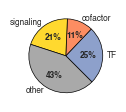

In [46]:
ys = np.array([len(cats_y2h[cats_y2h["category"] == "TF"]), len(cats_y2h[cats_y2h["category"] == "cofactor"]),
               len(cats_y2h[cats_y2h["category"] == "signaling"]),
               len(cats_y2h[cats_y2h["category"] == "other"])])
labels = ["TF", "cofactor", "signaling", "other"]
colors = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[1], sns.color_palette("Set2")[5], "darkgray"]

fig, ax = plt.subplots(figsize=(1.2, 1.2), subplot_kw=dict(aspect="equal"))
ws, ls, ns = ax.pie(ys, 
                    colors=colors, 
                    labels=labels, 
                    autopct='%1.0f%%', 
                    startangle=-45, 
                    #explode=(0.02, 0.2, 0.05, 0.05),
                    )

for n, w in zip(ns, ws):
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
    n.set_fontweight("bold")
    n.set_fontsize(6)

fig.savefig("../../figures/fig4/PPIs-gene-level-manual-categories_simplified.pdf", dpi="figure", bbox_inches="tight")

In [47]:
cofactor_partners = set(cats_y2h.loc[cats_y2h['category'] == 'cofactor', 'gene_symbol_partner'].unique())
signaling_partners = set(cats_y2h.loc[cats_y2h['category'] == 'signaling', 'gene_symbol_partner'].unique())
other_partners = set(cats_y2h.loc[cats_y2h['category'] == 'other', 'gene_symbol_partner'].unique())
tf_gene_symbols = set(load_human_tf_db()['HGNC symbol'].values)

coactivator_partners = set(cats_y2h.loc[cats_y2h['cofactor_type'] == 'coactivator', 'gene_symbol_partner'].unique())
corepressor_partners = set(cats_y2h.loc[cats_y2h['cofactor_type'] == 'corepressor', 'gene_symbol_partner'].unique())

In [48]:
cats_y2h.cofactor_type.value_counts()

cofactor_type
unknown        42
corepressor     7
coactivator     6
both            3
Name: count, dtype: int64

In [49]:
list(signaling_partners)[25:35]

['TNIP3',
 'MOAP1',
 'IL16',
 'PIK3R3',
 'TRIM38',
 'NABP1',
 'PIBF1',
 'MID2',
 'BCL2L2',
 'FRS3']

In [50]:
# make a similar pie chart but this time focusing on protein categories that get rewired across isoforms

In [51]:
ppi = load_y2h_isoform_data(require_at_least_one_ppi_per_isoform=True)
ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])['Y2H_result'].apply(lambda x: (x == False).sum()).reset_index()

,ad_gene_symbol,db_gene_symbol,Y2H_result
0,ARNT2,EIF3E,0
1,ARNT2,LMO3,0
2,ARNT2,NABP1,0
3,ARNT2,NPAS2,0
4,ARNT2,NRBP1,0
...,...,...,...
931,ZSCAN18,ZNF792,1
932,ZSCAN18,ZSCAN22,1
933,ZSCAN9,SCAND1,1
934,ZSCAN9,SRPK2,1


In [52]:
a = ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])['Y2H_result'].apply(lambda x: (x == False).sum()).reset_index()
tot = ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])['Y2H_result'].apply(lambda x: (x.notnull().sum())).reset_index()
rw = tot.merge(a, on=["ad_gene_symbol", "db_gene_symbol"], how="left")
rw["rewiring_score"] = rw["Y2H_result_y"]/rw["Y2H_result_x"]
rw.sample(5)

,ad_gene_symbol,db_gene_symbol,Y2H_result_x,Y2H_result_y,rewiring_score
438,TCF12,C1orf50,3,1,0.333333
916,ZNF451,ZNF408,4,3,0.750000
234,MEIS2,HCK,3,1,0.333333
893,ZNF451,TRAF3IP3,4,3,0.750000
490,TCF12,NEK6,3,1,0.333333


In [53]:
# anything w a rewiring score > 0 is rewired
rewired_ppis = rw[rw["rewiring_score"] > 0]
cats_y2h_rw = cats_y2h[cats_y2h["gene_symbol_partner"].isin(rewired_ppis["db_gene_symbol"])]
len(cats_y2h_rw)

397

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


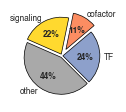

In [54]:
ys = np.array([len(cats_y2h_rw[cats_y2h_rw["category"] == "TF"]), 
               len(cats_y2h_rw[cats_y2h_rw["category"] == "cofactor"]),
               len(cats_y2h_rw[cats_y2h_rw["category"] == "signaling"]),
               len(cats_y2h_rw[cats_y2h_rw["category"] == "other"])])
labels = ["TF", "cofactor", "signaling", "other"]
colors = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[1], sns.color_palette("Set2")[5], "darkgray"]

fig, ax = plt.subplots(figsize=(1.2, 1.2), subplot_kw=dict(aspect="equal"))
ws, ls, ns = ax.pie(ys, colors=colors, labels=labels, autopct='%1.0f%%', startangle=-45, 
                    explode=(0.02, 0.2, 0.05, 0.05))

for n, w in zip(ns, ws):
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
    n.set_fontweight("bold")
    n.set_fontsize(6)

fig.savefig("../../figures/fig4/PPIs-gene-level-manual-categories_simplified.rewired_only.pdf", dpi="figure", bbox_inches="tight")

## 7. plot the relationship between gain/loss of PPIs and changes in activity

In [55]:
def add_restricted_ppi_columns(pairs, rows, label):
    pairs_cf = pairs[['clone_acc_ref', 'clone_acc_alt']].copy()
    _add_PPI_columns(df=pairs_cf, y2h=y2h.loc[rows, :])
    return pd.merge(pairs, 
                    pairs_cf,
                    how='left',
                    on=['clone_acc_ref', 'clone_acc_alt'],
                    suffixes=('', '_' + label))

In [56]:
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(cofactor_partners),
                           label='cofactors'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(cofactor_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='cofactors_HEK'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(coactivator_partners),
                           label='coactivators'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(coactivator_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='coactivators_HEK'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(corepressor_partners),
                           label='corepressors'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(corepressor_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='corepressors_HEK'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(signaling_partners),
                           label='signaling'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(signaling_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='signaling_HEK'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(tf_gene_symbols),
                           label='tfs'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(tf_gene_symbols) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='tfs_HEK'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(other_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='other_HEK'
)

In [57]:
def bar_activation_vs_ppi(x, y, pairs=pairs, x_label=None, y_label=None, color=None):
    df = pairs.copy()
    if x_label is None:
        x_label = x
    if y_label is None:
        y_label = y
    if color is None:
        color = sns.color_palette("Set2")[1]
    fig, ax = plt.subplots(1, 1, figsize=(1.15, 1.5))

    def bin_delta_ppi(delta_ppi):
        if pd.isnull(delta_ppi):
            return np.nan
        if delta_ppi < 0:
            return 'change'
        elif delta_ppi > 0:
            return 'change'
        elif delta_ppi == 0:
            return 'equal'
        else:
            raise ValueError(delta_ppi)


    df[x + '_binned'] = df[x].apply(bin_delta_ppi)
    sns.stripplot(data=df,
                  x=x + '_binned',
                  y=y,
                  order=['equal', 'change'],
                  alpha=0.75,
                  color=color,
                  linewidth=1,
                  edgecolor="black",
                  ax=ax)
    if False:
        sns.pointplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['equal', 'change'],
                    alpha=0.5,
                    color='black',
                    ax=ax)
    if True:
        sns.boxplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['equal', 'change'],
                    fliersize=0,
                    color=color,
                    ax=ax)
        mimic_r_boxplot(ax)
    else:
        sns.violinplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['equal', 'change'],
                    color='lightgrey',
                    ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    with_data = (df[x].notnull() & df[y].notnull())
    n_pair = with_data.sum()
    n_iso = len(set(df.loc[with_data, ['clone_acc_ref', 'clone_acc_alt']].values.flatten()))
    n_gene = df.loc[with_data, 'gene_symbol'].nunique()
    
    dist_a = df[df[x + '_binned'] == 'equal'][y].values
    dist_b = df[df[x + '_binned'] == 'change'][y].values
    u, p = stats.mannwhitneyu(dist_a, dist_b, alternative="less")
    plotting.annotate_pval(ax, 0.2, 0.8, 2.4, 0, 2.4, p, 7)
    
    ax.text(s=f'{n_pair:d} pairs\n{n_iso:d} isoforms\n{n_gene:d} genes\np = {p:.2f}',
            x=1.03,
            y=0.95,
            ha='left',
            va='top',
            transform=ax.transAxes)
    #ax.set_ylim(-4, 4) # NOTE cuts outlier TODO add broken axis
    ax.set_ylim(0, 4)

    for pos in ['top', 'bottom', 'right']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    fig.savefig(f'../../figures/fig4/{x}-vs-{y}_scatter.pdf',
                bbox_inches='tight')

In [58]:
pairs['activation_abs_fold_change'] = pairs['activation_fold_change_log2'].abs()

/tmp/ipykernel_201029/3666337037.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pairs['activation_abs_fold_change'] = pairs['activation_fold_change_log2'].abs()


In [59]:
# limit to pairs w signal in m1h
df = pairs.copy()
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
len(df)

254

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


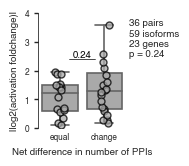

In [60]:
bar_activation_vs_ppi(
    pairs=df.loc[df['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_other_HEK',
    y='activation_abs_fold_change',
    x_label='Net difference in number of PPIs',
    y_label='|log2(activation foldchange)|',
    color="darkgrey")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


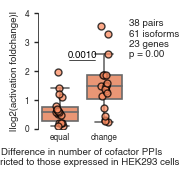

In [61]:
bar_activation_vs_ppi(
    pairs=df.loc[df['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_cofactors_HEK',
    y='activation_abs_fold_change',
    x_label='Difference in number of cofactor PPIs\nrestricted to those expressed in HEK293 cells',
    y_label='|log2(activation foldchange)|',
    color=sns.color_palette("Set2")[1])

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


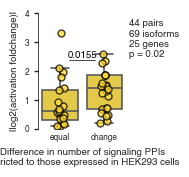

In [62]:
bar_activation_vs_ppi(
    pairs=df.loc[df['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_signaling_HEK',
    y='activation_abs_fold_change',
    x_label='Difference in number of signaling PPIs\nrestricted to those expressed in HEK293 cells',
    y_label='|log2(activation foldchange)|',
    color=sns.color_palette("Set2")[5])

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


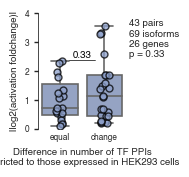

In [63]:
bar_activation_vs_ppi(
    pairs=df.loc[df['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_tfs_HEK',
    y='activation_abs_fold_change',
    x_label='Difference in number of TF PPIs\nrestricted to those expressed in HEK293 cells',
    y_label='|log2(activation foldchange)|',
    color=sns.color_palette("Set2")[2])

## 7. dimerizing TFs: plot conservation of interactions across isoforms

In [64]:
ppi = load_y2h_isoform_data(require_at_least_one_ppi_per_isoform=True)
ppi.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result
0,ATF2|1/6|12H04,ATF2,ATF2,True
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN
4,ATF2|1/6|12H04,ATF2,JDP2,True
12,ATF2|2/6|09E05,ATF2,ATF2,True
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN


In [65]:
n_iso_per_ppi = (ppi.groupby(['ad_gene_symbol', 'db_gene_symbol']))['ad_clone_acc'].agg("count").reset_index()
n_true_iso_per_ppi = (ppi[ppi['Y2H_result'] == True].groupby(['ad_gene_symbol', 
                                                              'db_gene_symbol']))['ad_clone_acc'].agg("count").reset_index()
n_iso_per_ppi = n_iso_per_ppi.merge(n_true_iso_per_ppi, on=['ad_gene_symbol', 'db_gene_symbol'], how='left')
n_iso_per_ppi['f_iso_positive'] = n_iso_per_ppi['ad_clone_acc_y']/n_iso_per_ppi['ad_clone_acc_x']
n_iso_per_ppi = n_iso_per_ppi[['ad_gene_symbol', 'db_gene_symbol', 'f_iso_positive']]
n_iso_per_ppi

,ad_gene_symbol,db_gene_symbol,f_iso_positive
0,ARNT2,EIF3E,1.0
1,ARNT2,LMO3,1.0
2,ARNT2,NABP1,1.0
3,ARNT2,NPAS2,1.0
4,ARNT2,NRBP1,1.0
...,...,...,...
931,ZSCAN18,ZNF792,0.5
932,ZSCAN18,ZSCAN22,0.5
933,ZSCAN9,SCAND1,0.5
934,ZSCAN9,SRPK2,0.5


In [66]:
# isoform-variable PPIs are ones that the fraction positive is < 1
iso_variable = len(n_iso_per_ppi[n_iso_per_ppi['f_iso_positive'] < 1])
print("NUMBER OF PPIs THAT VARY ACROSS ISOFORMS: %s" % iso_variable)
print("PERCENT OF PPIS THAT VARY ACROSS ISOFORMS: %s" % (iso_variable/len(n_iso_per_ppi)*100))

NUMBER OF PPIs THAT VARY ACROSS ISOFORMS: 684
PERCENT OF PPIS THAT VARY ACROSS ISOFORMS: 73.07692307692307


In [67]:
n_iso_per_ppi = pd.merge(n_iso_per_ppi,
                         ppi.groupby(['ad_gene_symbol',
                                      'db_gene_symbol'])
                                ['Y2H_result']
                                .apply(lambda x: x.notnull().sum())
                                .rename('n_iso_successfully_tested')
                                .reset_index(),
                            how='left',
                            on=['ad_gene_symbol', 'db_gene_symbol'],
                            )
if n_iso_per_ppi['n_iso_successfully_tested'].isnull().any():
    raise UserWarning('unexpected missing values')
n_iso_per_ppi = n_iso_per_ppi.loc[n_iso_per_ppi['n_iso_successfully_tested'] >= 2, :]

In [68]:
tf_fam = load_tf_families()

In [69]:
n_iso_per_ppi['db_is_tf'] = n_iso_per_ppi['db_gene_symbol'].isin(tf_fam)
n_iso_per_ppi['ad_tf_family'] = n_iso_per_ppi['ad_gene_symbol'].map(tf_fam)
n_iso_per_ppi['db_tf_family'] = n_iso_per_ppi['db_gene_symbol'].map(tf_fam)

In [70]:
def tf_tf_dimer_ppi_catagories(row):
    is_dimer_ad = row['ad_tf_family'] in DIMERIZING_TF_FAMILIES
    if pd.isnull(row['db_tf_family']):
        if is_dimer_ad:
            return 'Obligate dimer TF / other'
        else:
            return 'Non obligate dimer TF / other'
    else:  # TF-TF PPI
        if is_dimer_ad:
            if row['db_tf_family'] == row['ad_tf_family']:
                return 'Obligate dimer TF / within-family TF'
            else:
                return 'Obligate dimer TF / other'
        else:
            if row['db_tf_family'] == row['ad_tf_family']:
                return 'Non obligate dimer TF / within-family TF'
            else:
                return 'Non obligate dimer TF / other'


n_iso_per_ppi['dimer_cat'] = n_iso_per_ppi.apply(tf_tf_dimer_ppi_catagories,
                                                 axis=1)

n_iso_per_ppi.head()

,ad_gene_symbol,db_gene_symbol,f_iso_positive,n_iso_successfully_tested,db_is_tf,ad_tf_family,db_tf_family,dimer_cat
0,ARNT2,EIF3E,1.0,2,False,bHLH,NaN,Obligate dimer TF / other
1,ARNT2,LMO3,1.0,2,False,bHLH,NaN,Obligate dimer TF / other
2,ARNT2,NABP1,1.0,2,False,bHLH,NaN,Obligate dimer TF / other
3,ARNT2,NPAS2,1.0,2,False,bHLH,bHLH,Obligate dimer TF / within-family TF
4,ARNT2,NRBP1,1.0,2,False,bHLH,NaN,Obligate dimer TF / other


In [71]:
cats = [
 'Obligate dimer TF / within-family TF',
 'Obligate dimer TF / other',
 'Non obligate dimer TF / within-family TF',
 'Non obligate dimer TF / other',
 ]

In [72]:
n_iso_per_ppi.dimer_cat.value_counts()

dimer_cat
Obligate dimer TF / other                   409
Non obligate dimer TF / other               400
Non obligate dimer TF / within-family TF     73
Obligate dimer TF / within-family TF         54
Name: count, dtype: int64

In [73]:
for cat in cats:
    print("%s | # unique TF genes: %s" % (cat, 
                                          len(n_iso_per_ppi[n_iso_per_ppi["dimer_cat"] == cat].ad_gene_symbol.unique())))

Obligate dimer TF / within-family TF | # unique TF genes: 19
Obligate dimer TF / other | # unique TF genes: 28
Non obligate dimer TF / within-family TF | # unique TF genes: 21
Non obligate dimer TF / other | # unique TF genes: 33


In [74]:
def permutation_test(sample1, sample2, num_permutations=1000, seed=None, alternative='two-sided'):
    """
    Conduct a permutation test on two samples.

    :param sample1: First sample (array-like)
    :param sample2: Second sample (array-like)
    :param num_permutations: Number of permutations to perform (int)
    :param seed: Seed for random number generator (int)
    :param alternative: Defines the alternative hypothesis. 
                        'two-sided': the distributions are not equal,
                        'less': the distribution of sample1 is less than the distribution of sample2,
                        'greater': the distribution of sample1 is greater than the distribution of sample2
    :return: p-value (float)
    """

    # Ensure reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Combine the samples
    combined = np.concatenate([sample1, sample2])

    # Calculate the observed test statistic
    observed_stat = np.mean(sample1) - np.mean(sample2)

    # Perform the permutations
    count = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_sample_1 = combined[:len(sample1)]
        new_sample_2 = combined[len(sample1):]

        # Calculate the new test statistic
        new_stat = np.mean(new_sample_1) - np.mean(new_sample_2)

        # Check if the new test statistic is at least as extreme as the original
        if alternative == 'two-sided':
            count += abs(new_stat) >= abs(observed_stat)
        elif alternative == 'less':
            count += new_stat <= observed_stat
        elif alternative == 'greater':
            count += new_stat >= observed_stat
        else:
            raise ValueError("alternative must be 'two-sided', 'less', or 'greater'")

    # Calculate the p-value
    p_value = (count + 1) / (num_permutations + 1)

    return p_value

In [75]:
def bootstrap_99_ci(series, n_bootstraps=1000):
    """
    Calculate the 95% confidence interval using bootstrapping.
    
    :param series: Data points as a pandas Series.
    :param n_bootstraps: Number of bootstrap iterations.
    :return: A tuple containing the lower and upper confidence interval bounds.
    """
    bootstrapped_means = []
    for _ in range(n_bootstraps):
        sample = series.sample(n=len(series), replace=True)  # Sampling with replacement
        sample_mean = sample.mean()
        bootstrapped_means.append(sample_mean)

    lower, upper = np.percentile(bootstrapped_means, [0.5, 99.5])  # 99% confidence interval
    return lower, upper

9.999000099990002e-05
pair: ('Obligate dimer TF / within-family TF', 'Obligate dimer TF / other') | p-val: 9.999000099990002e-05
9.999000099990002e-05
pair: ('Obligate dimer TF / within-family TF', 'Non obligate dimer TF / within-family TF') | p-val: 9.999000099990002e-05


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


9.999000099990002e-05
pair: ('Obligate dimer TF / within-family TF', 'Non obligate dimer TF / other') | p-val: 9.999000099990002e-05


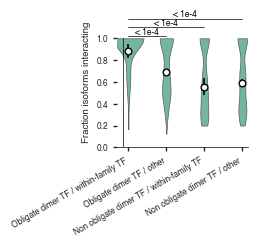

In [76]:
# n for each bar
# axis labels etc.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.7, h=1.7)
violinplot_reflected(data=n_iso_per_ppi,
              x='dimer_cat',
              y='f_iso_positive',
              inner=None,
              cut=0,
              color=sns.color_palette("Set2")[0],
              order=cats,
              alpha=0.75,
              linewidth=0.5,
              ax=ax)

# add markers for mean + 95% ci [avoids using pointplot which is not that customizable, aesthetically]
means = n_iso_per_ppi.groupby("dimer_cat")["f_iso_positive"].agg("mean").reset_index()
cis = n_iso_per_ppi.groupby("dimer_cat")["f_iso_positive"].apply(bootstrap_99_ci).reset_index()
cis[['lower', 'upper']] = pd.DataFrame(cis['f_iso_positive'].tolist(), index=cis.index)

# reorder so they're in the same order
cis.set_index("dimer_cat", inplace=True)
means_tmp = means.set_index("dimer_cat")
cis = cis.loc[cats, :]
means_tmp = means_tmp.loc[cats, :]

# add points
sns.swarmplot(data=means, x='dimer_cat', y='f_iso_positive', order=cats, ax=ax,
              color="white", edgecolor="black", linewidth=0.25, size=4)
ax.errorbar(x=range(len(cats)), y=means_tmp["f_iso_positive"], 
            yerr=[means_tmp["f_iso_positive"] - cis["lower"], cis["upper"] - means_tmp["f_iso_positive"]], 
            fmt='o', color="black")

# now add p-vals
pairs_to_test = [(cats[0], cat) for cat in cats[1:]]
for i, pair in enumerate(pairs_to_test):
    x = n_iso_per_ppi[n_iso_per_ppi["dimer_cat"] == pair[0]]["f_iso_positive"].values
    y = n_iso_per_ppi[n_iso_per_ppi["dimer_cat"] == pair[1]]["f_iso_positive"].values
    p = permutation_test(x, y, num_permutations=10000, alternative="two-sided", seed=2023)
    print(p)
    annotate_pval(ax, 0, 1+i, 1.02+(i*0.08), 0, 1.02+(i*0.08), p, fontsize-1, text="< 1e-4")
    print("pair: %s | p-val: %s" % (pair, p))

ax.set_ylabel('Fraction isoforms interacting', position=(0, 0.425))
ax.set_xlabel('')

ax.set_xticklabels(cats, rotation=30, ha='right', va='top')

ax.set_ylim(0, 1.2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# manually set left axis so it stops at 1.0
ax.spines['left'].set_visible(False)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes_to_data = ax.transAxes + ax.transData.inverted()
left_spine_in_data_coords = axes_to_data.transform((0, 0))
ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [left_spine_in_data_coords[0], 1],
        color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())



fig.savefig('../../figures/fig4/n_iso_ppi_by_dimer_cat.pdf',
            bbox_inches='tight')

In [77]:
n_iso_per_ppi[n_iso_per_ppi["ad_gene_symbol"] == "ATF2"]

,ad_gene_symbol,db_gene_symbol,f_iso_positive,n_iso_successfully_tested,db_is_tf,ad_tf_family,db_tf_family,dimer_cat
13,ATF2,ATF2,0.500000,6,False,bZIP,bZIP,Obligate dimer TF / within-family TF
14,ATF2,FOSL2,0.166667,3,False,bZIP,bZIP,Obligate dimer TF / within-family TF
15,ATF2,JDP2,0.666667,6,False,bZIP,bZIP,Obligate dimer TF / within-family TF
16,ATF2,MAPK9,0.666667,6,False,bZIP,NaN,Obligate dimer TF / other


## 8. dimerizing TFs: plot M1H change

In [78]:
len(pairs)

447

In [79]:
len(pairs[~pd.isnull(pairs['activation_abs_fold_change'])])

327

In [80]:
# limit to pairs w signal in m1h
df = pairs.copy()
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
len(df)

254

In [81]:
df[~pd.isnull(df['activation_abs_fold_change'])].groupby("is_dimerizing_TF_family")["activation_abs_fold_change"].agg("mean")

is_dimerizing_TF_family
False    1.248606
True     1.543294
Name: activation_abs_fold_change, dtype: float64

In [82]:
df[~pd.isnull(df['activation_abs_fold_change'])].groupby("is_dimerizing_TF_family")["activation_abs_fold_change"].agg("median")

is_dimerizing_TF_family
False    0.839813
True     1.077391
Name: activation_abs_fold_change, dtype: float64

In [83]:
df_nonan = df[~pd.isnull(df["activation_abs_fold_change"])]
x = df_nonan[df_nonan["is_dimerizing_TF_family"] == True]["activation_abs_fold_change"].values
y = df_nonan[df_nonan["is_dimerizing_TF_family"] == False]["activation_abs_fold_change"].values

permutation_test(x, y, num_permutations=10000, alternative="two-sided")

0.0775922407759224

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


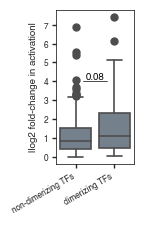

In [84]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1, h=2)

ax = sns.boxplot(data=df, x="is_dimerizing_TF_family", y="activation_abs_fold_change", 
                 flierprops={"marker": "o"}, color="slategrey")
mimic_r_boxplot(ax)

# p-value
df_nonan = df[~pd.isnull(df["activation_abs_fold_change"])]
x = df_nonan[df_nonan["is_dimerizing_TF_family"] == True]["activation_abs_fold_change"].values
y = df_nonan[df_nonan["is_dimerizing_TF_family"] == False]["activation_abs_fold_change"].values

pval = permutation_test(x, y, num_permutations=10000, alternative="two-sided")
plotting.annotate_pval(ax, 0.2, 0.8, 4, 0, 4, pval, 7)

ax.set_xlabel("")
ax.set_xticklabels(["non-dimerizing TFs", "dimerizing TFs"], rotation=30, ha="right", va="top")
ax.set_ylabel("|log2 fold-change in activation|")

fig.savefig("../../figures/fig4/M1H_activ_v_dimerization.pdf", dpi="figure", bbox_inches="tight")

## 9. dimerizing TFs: retained interactions heatmap

In [85]:
# TF isoforms are on the 'ad' side; ORFeome on 'db' side
ppi.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result
0,ATF2|1/6|12H04,ATF2,ATF2,True
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN
4,ATF2|1/6|12H04,ATF2,JDP2,True
12,ATF2|2/6|09E05,ATF2,ATF2,True
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN


In [86]:
# TF-TF binding
tftf = ppi.loc[ppi['Y2H_result'] == True, ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().copy()
tftf['ad_dbd'] = tftf['ad_gene_symbol'].map(tf_fam)
tftf['db_dbd'] = tftf['db_gene_symbol'].map(tf_fam)
tftf = tftf.dropna()
tftf.head()

,ad_gene_symbol,db_gene_symbol,ad_dbd,db_dbd
0,ATF2,ATF2,bZIP,bZIP
4,ATF2,JDP2,bZIP,bZIP
39,ATF2,FOSL2,bZIP,bZIP
123,CREB5,FOSL2,bZIP,bZIP
155,GLI1,PIN1,C2H2 ZF,MBD


In [87]:
# TF-TF rewiring
tftf = pd.merge(tftf, 
        (ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])['Y2H_result'].apply(lambda x: (x == False).sum()) / 
 ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])['Y2H_result'].apply(lambda x: (x.notnull().sum()))).reset_index(),
        how='left',
        on=['ad_gene_symbol', 'db_gene_symbol'])

In [88]:
tftf.loc[tftf['db_dbd'] == 'bHLH', 'ad_gene_symbol'].value_counts()

ad_gene_symbol
TCF4      12
TCF12     11
ARNTL2     2
ARNT2      2
ESRRA      2
MEOX1      2
FOS        1
ZBTB44     1
IKZF2      1
ZNF438     1
ESRRG      1
Name: count, dtype: int64

In [89]:
DIMERIZING_TF_FAMILIES

{'AP-2',
 'ARID/BRIGHT',
 'BED ZF',
 'CENPB',
 'E2F',
 'EBF1',
 'GCM',
 'Grainyhead',
 'HSF',
 'IRF',
 'MADF',
 'MADS box',
 'Myb/SANT',
 'Nuclear receptor',
 'RFX',
 'Rel',
 'SAND',
 'SMAD',
 'STAT',
 'bHLH',
 'bZIP',
 'p53'}

In [90]:
fams = tf_fam.value_counts().index
fams = list(filter(lambda x: x in tftf['ad_dbd'].unique() or x in tftf['db_dbd'].unique(), fams))
len(fams)

30

In [91]:
num_pairs = [((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y)).sum() for x in fams for y in fams]
num_pairs = np.reshape(num_pairs, (-1, len(fams)))
num_pairs = pd.DataFrame(num_pairs, index=fams, columns=fams)
num_pairs.head()

,C2H2 ZF,Homeodomain,bHLH,Unknown,bZIP,Forkhead,Nuclear receptor,HMG/Sox,Ets,T-box,...,C2H2 ZF; AT hook,C2H2 ZF; Homeodomain,CCCH ZF,TBP,p53,C2H2 ZF; BED ZF,CSL,Pipsqueak,CBF/NF-Y,TCR/CxC
C2H2 ZF,55,7,3,1,0,0,2,2,0,1,...,1,0,2,0,0,1,0,0,0,1
Homeodomain,7,14,2,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
bHLH,7,7,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Unknown,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bZIP,1,0,1,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
rewiring = [tftf.loc[(tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y), 'Y2H_result'].mean() for x in fams for y in fams]
rewiring = np.reshape(rewiring, (-1, len(fams)))
rewiring = pd.DataFrame(rewiring, index=fams, columns=fams)
rewiring.head()

,C2H2 ZF,Homeodomain,bHLH,Unknown,bZIP,Forkhead,Nuclear receptor,HMG/Sox,Ets,T-box,...,C2H2 ZF; AT hook,C2H2 ZF; Homeodomain,CCCH ZF,TBP,p53,C2H2 ZF; BED ZF,CSL,Pipsqueak,CBF/NF-Y,TCR/CxC
C2H2 ZF,0.524545,0.333333,0.588889,0.666667,NaN,NaN,0.750000,0.625,NaN,0.75,...,0.75,NaN,0.583333,NaN,NaN,0.0,NaN,NaN,NaN,0.333333
Homeodomain,0.476190,0.214286,0.666667,0.500000,NaN,NaN,0.666667,NaN,0.333333,NaN,...,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN
bHLH,0.369048,0.352891,0.021605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bZIP,0.000000,NaN,0.000000,NaN,0.153846,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# since rewiring score is 1-fraction isos interacting, we decided to just go with that
rewiring = 1-rewiring
rewiring.head()

,C2H2 ZF,Homeodomain,bHLH,Unknown,bZIP,Forkhead,Nuclear receptor,HMG/Sox,Ets,T-box,...,C2H2 ZF; AT hook,C2H2 ZF; Homeodomain,CCCH ZF,TBP,p53,C2H2 ZF; BED ZF,CSL,Pipsqueak,CBF/NF-Y,TCR/CxC
C2H2 ZF,0.475455,0.666667,0.411111,0.333333,NaN,NaN,0.250000,0.375,NaN,0.25,...,0.25,NaN,0.416667,NaN,NaN,1.0,NaN,NaN,NaN,0.666667
Homeodomain,0.523810,0.785714,0.333333,0.500000,NaN,NaN,0.333333,NaN,0.666667,NaN,...,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,NaN
bHLH,0.630952,0.647109,0.978395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bZIP,1.000000,NaN,1.000000,NaN,0.846154,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
tftf[(tftf["ad_dbd"] == "Homeodomain") & (tftf["db_dbd"] == "bHLH")].Y2H_result.mean()

0.6666666666666666

In [95]:
len(tftf[(tftf["ad_dbd"] == "Homeodomain") & (tftf["db_dbd"] == "bHLH")])

2

In [96]:
tftf[(tftf["ad_dbd"] == "bHLH") & (tftf["db_dbd"] == "Homeodomain")].Y2H_result.mean()

0.35289115646258506

In [97]:
len(tftf[(tftf["ad_dbd"] == "bHLH") & (tftf["db_dbd"] == "Homeodomain")])

7

confirming that AD is on the rows and DB is on the columns as expected

In [98]:
# limit to fams w 5 DB and remove 'unknown' DBDs
num_pairs_sum = num_pairs.sum(axis=0)
filt_fams = num_pairs_sum[num_pairs_sum >= 5]
filt_fams = filt_fams[filt_fams.index != "Unknown"]
filt_fams

C2H2 ZF             81
Homeodomain         38
bHLH                36
bZIP                14
Nuclear receptor    10
SMAD                 5
MBD                 13
dtype: int64

In [99]:
rewiring_filt = rewiring.loc[list(filt_fams.index), list(filt_fams.index)]
rewiring_filt

,C2H2 ZF,Homeodomain,bHLH,bZIP,Nuclear receptor,SMAD,MBD
C2H2 ZF,0.475455,0.666667,0.411111,NaN,0.250000,0.333333,1.000000
Homeodomain,0.523810,0.785714,0.333333,NaN,0.333333,0.333333,0.458333
bHLH,0.630952,0.647109,0.978395,NaN,NaN,0.750000,1.000000
bZIP,1.000000,NaN,1.000000,0.846154,NaN,NaN,1.000000
Nuclear receptor,0.750000,0.750000,1.000000,NaN,0.928571,NaN,NaN
SMAD,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
MBD,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


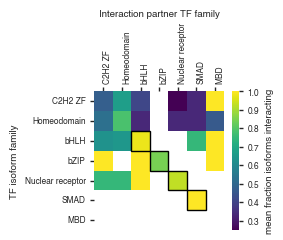

In [100]:
fig = plt.figure(figsize=(2.1, 1.8))

g = sns.heatmap(rewiring_filt, cmap="viridis", cbar_kws={"label": "mean fraction isoforms interacting"})

# highlight the squares corresponding to dimerizing pairs
for i, fam in enumerate(list(filt_fams.index)):
    if fam in DIMERIZING_TF_FAMILIES:
        g.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=1))
        
g.set_ylabel("TF isoform family")
g.set_xlabel("Interaction partner TF family")
g.xaxis.tick_top()
g.xaxis.set_label_position('top')
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="left", va="bottom")
ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)
fig.savefig("../../figures/fig4/Dimerizing_PPI_heatmap.small.pdf", dpi="figure", bbox_inches="tight")

In [101]:
filt_fams = list(rewiring_filt.columns)
filt_fams

['C2H2 ZF', 'Homeodomain', 'bHLH', 'bZIP', 'Nuclear receptor', 'SMAD', 'MBD']

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


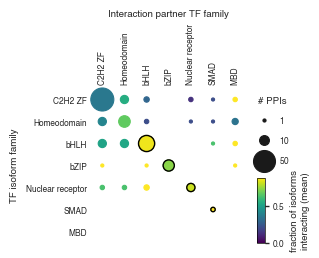

In [102]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
scaling = 5
sc = ax.scatter(x=[x for x in filt_fams for y in filt_fams],
                y=[y for x in filt_fams for y in filt_fams],
                s=[((tftf['db_dbd'] == x) & (tftf['ad_dbd'] == y)).sum() * scaling for x in filt_fams for y in filt_fams],
                c=[tftf.loc[(tftf['db_dbd'] == x) & (tftf['ad_dbd'] == y), 'Y2H_result'].mean() for x in filt_fams for y in filt_fams],
                cmap='viridis_r',
                vmin=0,
                vmax=7/8,
                clip_on=False)

dm = ax.scatter(x=[x for x in filt_fams for y in filt_fams if x in DIMERIZING_TF_FAMILIES and y in DIMERIZING_TF_FAMILIES and x == y],
                y=[y for x in filt_fams for y in filt_fams if x in DIMERIZING_TF_FAMILIES and y in DIMERIZING_TF_FAMILIES and x == y],
                s=[((tftf['db_dbd'] == x) & (tftf['ad_dbd'] == y)).sum() * scaling for x in filt_fams for y in filt_fams if x in DIMERIZING_TF_FAMILIES and y in DIMERIZING_TF_FAMILIES and x == y],
                c=[tftf.loc[(tftf['db_dbd'] == x) & (tftf['ad_dbd'] == y), 'Y2H_result'].mean() for x in filt_fams for y in filt_fams if x in DIMERIZING_TF_FAMILIES and y in DIMERIZING_TF_FAMILIES and x == y],
                cmap='viridis_r',
                vmin=0,
                vmax=7/8,
                edgecolor="black",
                linewidth=1,
                clip_on=False)

ax.xaxis.set_tick_params(rotation=90)
for s in ax.spines.values():
    s.set_visible(False)
    
ax.set_xlim(-0.5, len(filt_fams) - 0.5)
ax.set_ylim(len(filt_fams) - 0.5, -0.5)

ax.set_xlabel('Interaction partner TF family',
              fontsize=fontsize,
              labelpad=5)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_ylabel('TF isoform family',
              fontsize=fontsize,
              labelpad=5)

ax.legend(*sc.legend_elements('sizes',
                              num=[1, 10, 50],
                              func=lambda x: x / scaling),
          bbox_to_anchor=[1.01, 1],
          labelspacing=1.1,
          title='# PPIs',
          frameon=False,
          title_fontsize=fontsize)

cbax = ax.inset_axes([1.07, 0, 0.05, 0.42], transform=ax.transAxes)
fig.colorbar(mpl.cm.ScalarMappable(cmap='viridis', norm=mpl.colors.Normalize(vmin=0, vmax=7/8)),
             ax=ax,
             cax=cbax,
             orientation='vertical',
             fraction=0.02,
             label='fraction of isoforms\ninteracting (mean)')
ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)
fig.savefig('../../figures/fig4/Dimerizing_PPI_correlogram.small.pdf', bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


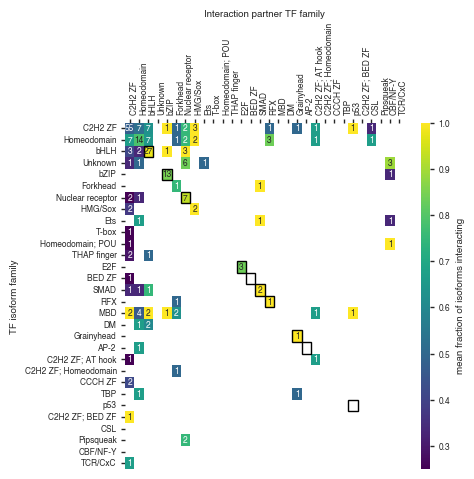

In [103]:
fig = plt.figure(figsize=(4.5, 4.5))
g = sns.heatmap(rewiring.T, cmap="viridis", cbar_kws={"label": "mean fraction of isoforms interacting", 
                                                      "aspect": 40},
                annot=num_pairs.T, annot_kws={"fontsize": 6})

# highlight the squares corresponding to dimerizing pairs
for i, fam in enumerate(list(rewiring.index)):
    if fam in DIMERIZING_TF_FAMILIES:
        g.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=1))
        
g.set_ylabel("TF isoform family")
g.set_xlabel("Interaction partner TF family")
g.xaxis.tick_top()
g.xaxis.set_label_position('top')
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="left", va="bottom")
ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)
fig.savefig("../../figures/fig4/Dimerizing_PPI_heatmap.all.pdf", dpi="figure", bbox_inches="tight")

## 10. domain-domain interactions plot

In [104]:
def load_3did_DDIs():
    fpath = '../../data/external/3did_flat_2022-05.txt'
    domain_pairs = []
    for line in open(fpath, 'r'):
        if line.startswith('#=ID'):
            domain_pairs.append((line.split()[3][1:8], line.split()[4][:7]))
    df = pd.DataFrame(data=domain_pairs, columns=['pfam_a', 'pfam_b'])
    if df.duplicated().any():
        raise UserWarning('unexpected duplicates')
    return df

In [105]:
pfam = load_pfam_domains_horfeome()
pfam['orf_id'] = pfam['orf_id'].astype(int)
pfam.head()

,orf_id,pfam_accession,domain_name,domain_description,start,stop,domain_length
10,1022,PF00812,Ephrin,Ephrin,31,163,139
16,6750,PF02089,Palm_thioest,Palmitoyl protein thioesterase,86,274,279
17,6750,PF00561,Abhydrolase_1,alpha/beta hydrolase fold,37,137,256
18,6750,PF00561,Abhydrolase_1,alpha/beta hydrolase fold,216,254,256
23,7051,PF14555,UBA_4,UBA-like domain,15,55,43


In [106]:
tf_pfam_domains = {tf.name: {dom.accession for iso in tf.cloned_isoforms
                             for dom in iso.aa_seq_features 
                             if dom.category == 'Pfam_domain'}
                   for tf in tfs.values()}

In [107]:
print(len(ppi))

ppi['gene_level_pair'] = ppi['ad_gene_symbol'] + '_' + ppi['db_gene_symbol']
ppi['ad_iso_id'] = ppi['ad_clone_acc'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
ppi.head()

3593


,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result,gene_level_pair,ad_iso_id
0,ATF2|1/6|12H04,ATF2,ATF2,True,ATF2_ATF2,ATF2-1
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN,ATF2_FOSL2,ATF2-1
4,ATF2|1/6|12H04,ATF2,JDP2,True,ATF2_JDP2,ATF2-1
12,ATF2|2/6|09E05,ATF2,ATF2,True,ATF2_ATF2,ATF2-2
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN,ATF2_FOSL2,ATF2-2


In [108]:
# code requires the orf id so map this using the full df
ppi_full = load_full_y2h_data_including_controls()
ppi = ppi.merge(ppi_full[['db_gene_symbol', 'db_orf_id']], on='db_gene_symbol', how='left')
ppi.sample(5)

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result,gene_level_pair,ad_iso_id,db_orf_id
6622,NFYA|3/3|11D05,NFYA,NRF1,False,NFYA_NRF1,NFYA-3,1011
54868,TCF4|7/9|07G03,TCF4,ATP11B,False,TCF4_ATP11B,TCF4-7,11179
69684,FOSB|1/3|05D03,FOSB,ATF2,True,FOSB_ATF2,FOSB-1,54731
79839,TCF12|2/3|07A09,TCF12,ASCL3,True,TCF12_ASCL3,TCF12-2,100014515
3450,FOXP2|1/10|07C01,FOXP2,AES,True,FOXP2_AES,FOXP2-1,53886


In [109]:
# check no-overlap with domain motif
ddi = load_3did_DDIs()

def matching_DDIs(row):
    if (
        pd.isnull(row['partner_domains']) or
        pd.isnull(row['tf_domains'])
        ):
        return np.nan
    if (
        len(row['partner_domains']) == 0 or
        len(row['tf_domains']) == 0
    ):
        return np.nan
    matches = ddi.loc[(ddi['pfam_a'].isin(row['partner_domains']) &
                    ddi['pfam_b'].isin(row['tf_domains'])) |
                   (ddi['pfam_a'].isin(row['tf_domains']) &
                    ddi['pfam_b'].isin(row['partner_domains']))].values
    if len(matches) == 0:
        return np.nan
    return frozenset((a, b) for a, b in matches)

partner_domains = pfam.groupby('orf_id')['pfam_accession'].apply(set)
ppi['partner_domains'] = ppi['db_orf_id'].map(partner_domains)
ppi['tf_domains'] = ppi['ad_gene_symbol'].map(tf_pfam_domains)
ppi['matching_DDI'] = ppi.apply(matching_DDIs, axis=1)
ppi.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result,gene_level_pair,ad_iso_id,db_orf_id,partner_domains,tf_domains,matching_DDI
0,ATF2|1/6|12H04,ATF2,ATF2,True,ATF2_ATF2,ATF2-1,54731,"{PF07716, PF00170}","{PF00096, PF00170}","((PF00170, PF07716), (PF00170, PF00170))"
1,ATF2|1/6|12H04,ATF2,ATF2,True,ATF2_ATF2,ATF2-1,54731,"{PF07716, PF00170}","{PF00096, PF00170}","((PF00170, PF07716), (PF00170, PF00170))"
2,ATF2|1/6|12H04,ATF2,ATF2,True,ATF2_ATF2,ATF2-1,54731,"{PF07716, PF00170}","{PF00096, PF00170}","((PF00170, PF07716), (PF00170, PF00170))"
3,ATF2|1/6|12H04,ATF2,ATF2,True,ATF2_ATF2,ATF2-1,54731,"{PF07716, PF00170}","{PF00096, PF00170}","((PF00170, PF07716), (PF00170, PF00170))"
4,ATF2|1/6|12H04,ATF2,ATF2,True,ATF2_ATF2,ATF2-1,54731,"{PF07716, PF00170}","{PF00096, PF00170}","((PF00170, PF07716), (PF00170, PF00170))"


In [110]:
ggi = ppi.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'db_orf_id', 'matching_DDI']].drop_duplicates()
print(len(ggi))
ggi.head()

936


,ad_gene_symbol,db_gene_symbol,db_orf_id,matching_DDI
0,ATF2,ATF2,54731,"((PF00170, PF07716), (PF00170, PF00170))"
31,ATF2,FOSL2,12504,"((PF00170, PF07716), (PF00170, PF00170))"
43,ATF2,JDP2,13624,"((PF00170, PF07716), (PF00170, PF03131), (PF00..."
330,ATF2,MAPK9,10051,"((PF00069, PF00096))"
684,CREB5,EFEMP2,2906,NaN


In [111]:
# domain removal
# for each alt iso, for each DDI, calc fraction of domain
# removed and fraction of PPIs retained
dom = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])

In [112]:
# filter and consolidate DDIs

ddi_annot = pd.read_csv('../../data/internal/DDI_manual_annotation.tsv', sep='\t')

valid_ddi_pairs = {frozenset(p) for p in ddi_annot.loc[ddi_annot['to_use'], ['pfam_a', 'pfam_b']].values}
def filter_ddi(pairs):
    if pd.isnull(pairs):
        return np.nan
    passed = frozenset(p for p in pairs if frozenset(p) in valid_ddi_pairs)
    if len(passed) == 0:
        return np.nan
    return passed

ddi_to_merge = {
    ('PF00170', 'PF07716'): ('PF00170', 'PF00170'),  # bZIP-bZIP
    ('PF00170', 'PF03131'): ('PF00170', 'PF00170'),  # bZIP-bZIP
    ('PF07716', 'PF07716'): ('PF00170', 'PF00170'),  # bZIP-bZIP
    ('PF03131', 'PF03131'): ('PF00170', 'PF00170'),  # bZIP-bZIP
    ('PF00046', 'PF05920'): ('PF00046',	'PF00046'),  # homeobox-homeobox
    ('PF05920', 'PF05920'): ('PF00046',	'PF00046'),  # homeobox-homeobox
    ('PF00989', 'PF14598'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF00989', 'PF08447'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF00989', 'PF13426'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF14598', 'PF14598'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF08447', 'PF14598'): ('PF00989', 'PF00989'),  # PAS-PAS
    ('PF08447', 'PF08447'): ('PF00989', 'PF00989'),  # PAS-PAS
}


In [113]:
df = ppi.loc[ppi['matching_DDI'].notnull(), :].copy()
ref_isos = {tf.cloned_reference_isoform.clone_acc for tf in tfs.values()}
positive_in_ref = df.loc[df['ad_clone_acc'].isin(ref_isos) & 
                         (df['Y2H_result'] == True), 'gene_level_pair'].unique()
df = df.loc[df['gene_level_pair'].isin(positive_in_ref) &
            ~df['ad_clone_acc'].isin(ref_isos), :]
df['matching_DDI'] = df['matching_DDI'].apply(filter_ddi)
df['matching_DDI'] = df['matching_DDI'].apply(lambda x: frozenset(ddi_to_merge.get(tuple(sorted(p)), tuple(sorted(p))) for p in x) if pd.notnull(x) else x)
df = df.loc[df['matching_DDI'].notnull(), :]

In [114]:
merged_domains = {'PF07716': 'PF00170',  # bZIP
 'PF03131': 'PF00170',  # bZIP
 'PF05920': 'PF00046',  # homeobox
'PF14598': 'PF00989',  # PAS
'PF08447': 'PF00989',  # PAS
'PF13426': 'PF00989',  # PAS
}
df['tf_domains'] = df['tf_domains'].apply(lambda x: {merged_domains.get(d, d) for d in x})
dom['accession'] = dom['accession'].apply(lambda x: merged_domains.get(x, x))


def pick_the_one_domain(row):
    ddi_domains = {x for a, b in row['matching_DDI'] for x in [a, b]}
    ds = {d for d in row['tf_domains'] if d in ddi_domains}
    if len(ds) == 0:
        print(row)
        raise UserWarning('something wrong')
    return ds

df['tf_domains'] = df.apply(pick_the_one_domain, axis=1)

def filter_for_domain_in_cloned_reference_isoform(row):
    in_ref = {d.accession for d in tfs[row['ad_gene_symbol']].cloned_reference_isoform.aa_seq_features}
    return {d for d in row['tf_domains'] if d in in_ref}


df['tf_domains'] = df.apply(filter_for_domain_in_cloned_reference_isoform, axis=1)
df = df.loc[df['tf_domains'].map(lambda x: len(x) > 0), :]

def fraction_of_DDI_domains_removed(row):
    ds = dom.loc[(dom['alt_iso'] == row['ad_iso_id']) 
                  & dom['accession'].isin(row['tf_domains']), :]
    if ds.shape[0] == 0:
        print(row)
        raise UserWarning('something wrong')
    return ds[['deletion', 'frameshift']].sum().sum() / ds['length'].sum()

def insertion_in_DDI_domains(row):
    ds = dom.loc[(dom['alt_iso'] == row['ad_iso_id']) 
                  & dom['accession'].isin(row['tf_domains']), :]
    return ds['insertion'].sum()

df['fraction_of_DDI_domains_removed'] = df.apply(fraction_of_DDI_domains_removed, axis=1)
df['insertion_in_DDI_domains'] = df.apply(insertion_in_DDI_domains, axis=1)

df['tf_domains'] = df['tf_domains'].apply(frozenset)

In [115]:
data = (df.loc[df['Y2H_result'].notnull(), :]
          .groupby(['ad_iso_id', 'tf_domains'])
          ['fraction_of_DDI_domains_removed']
          .mean()
          .to_frame())

nonan = df.loc[df['Y2H_result'].notnull(), :]
nonan['Y2H_result'] = nonan['Y2H_result'].astype(int)

data['Y2H_result_mean'] = nonan.groupby(['ad_iso_id', 'tf_domains'])['Y2H_result'].mean()
data['insertion_in_DDI_domains'] = nonan.groupby(['ad_iso_id', 'tf_domains'])['insertion_in_DDI_domains'].mean()


/tmp/ipykernel_201029/3777128348.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonan['Y2H_result'] = nonan['Y2H_result'].astype(int)


In [116]:
# TODO move to isolib
def n_aa_change_from_feature(gene, ref_iso_name, alt_iso_name, domain_start, domain_end):
    algn = gene.pairwise_changes_relative_to_reference(ref_iso_name, alt_iso_name)

    def _coords_transform_aa_seq_to_alignment(i, alignment):
        if i > len(alignment.replace("I", "")):
            raise ValueError("position is not in isoform AA sequence")
        aa_seq_indices = [
            "" if c == "I" else len(alignment[:j].replace("I", ""))
            for j, c in enumerate(alignment)
        ]
        return aa_seq_indices.index(i)
    
    start = _coords_transform_aa_seq_to_alignment(domain_start, algn)
    end = _coords_transform_aa_seq_to_alignment(domain_end - 1, algn) + 1

    if not all(x == 'M' for x in algn[start:end]):
        return 0  # change is within the domain
    
    big_number = 9999999999999999999999999
    c_dist = big_number
    n_dist = big_number
    for i, l in enumerate(reversed(algn[:start])):
        if l != 'M':
            c_dist = i + 1
            break
    for i, l in enumerate(algn[end:]):
        if l != 'M':
            n_dist = i + 1
            break
    if c_dist == big_number and n_dist == big_number:
        raise UserWarning('problem calculating distance')
    return min([c_dist, n_dist])


def n_aa_to_all_features(self, ref_iso_name):
    results = []
    ref_iso = self._iso_dict[ref_iso_name]
    row = {"gene": self.name, "ref_iso": ref_iso_name}
    for aa_feature in ref_iso.aa_seq_features:
        for alt_iso_name, alt_iso in self._iso_dict.items():
            if alt_iso_name == ref_iso_name:
                continue
            row.update(
                {
                    "alt_iso": alt_iso_name,
                    "accession": aa_feature.accession,
                    "category": aa_feature.category,
                    "start_in_ref_iso": aa_feature.start,
                    "end_in_ref_iso": aa_feature.end,
                    "length": aa_feature.end - aa_feature.start,
                }
            )
            row.update({"n_aa_change_to_domain": n_aa_change_from_feature(self, ref_iso_name, alt_iso_name, aa_feature.start, aa_feature.end)})
            results.append(row.copy())
    results = pd.DataFrame(results)
    return results

dist = pd.concat([n_aa_to_all_features(g, g.cloned_reference_isoform.name) for g in tfs.values()])

def get_dist(row):
    alt_iso, dom_accessions = row.name
    return dist.loc[(dist['alt_iso'] == alt_iso) & (dist['accession'].isin(dom_accessions)),
                    'n_aa_change_to_domain'].min()

data['domain_n_aa_to_change'] = data.apply(get_dist, axis=1)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


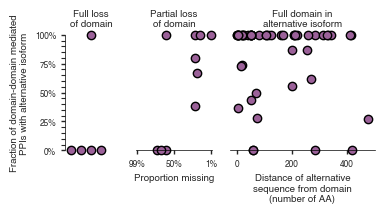

In [117]:
COLOR_PURPLE = (155 / 255, 97 / 255, 153 / 255)


gs_kw = dict(width_ratios=[0.7, 1, 1.9])

fig, axs = plt.subplots(1, 3, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=4, h=1.5)

point_size = 6

axs[0].set_title('Full loss\nof domain',
fontsize=PAPER_FONTSIZE)
sns.swarmplot(data=data.loc[data['fraction_of_DDI_domains_removed'] == 1, :],
              y='Y2H_result_mean', 
              x='fraction_of_DDI_domains_removed',
              size=point_size,
         #     order=[
         #            'Full loss\nof DBD',
         #            ],
            clip_on=False,
              ax=axs[0],
              color=COLOR_PURPLE,
              edgecolor='black',
              linewidth=1,
              alpha=1)

axs[1].set_title('Partial loss\nof domain',
fontsize=PAPER_FONTSIZE)
partial_loss = (data['fraction_of_DDI_domains_removed'] > 0) & (data['fraction_of_DDI_domains_removed'] < 1)
axs[1].scatter(data.loc[partial_loss, 'fraction_of_DDI_domains_removed'].values,
               data.loc[partial_loss, 'Y2H_result_mean'].values,
           alpha=1,
           s=point_size**2,  
            color=COLOR_PURPLE,
               edgecolor='black',
               linewidth=1,
           clip_on=False)
axs[1].set_xlabel('Proportion missing')
axs[1].set_xlim(1, 0)
axs[1].set_xticks([0.99, 0.5, 0.01])
axs[1].set_xticklabels([f'{x:.0%}' for x in axs[1].get_xticks()])
#axs[1].set_xticks(range(10, 91, 10), minor=True)



axs[2].set_title('Full domain in\nalternative isoform', fontsize=PAPER_FONTSIZE)
axs[2].scatter(data.loc[(data['fraction_of_DDI_domains_removed'] == 0), 'domain_n_aa_to_change'].values,
               data.loc[(data['fraction_of_DDI_domains_removed'] == 0), 'Y2H_result_mean'].values,
           alpha=1,
           s=point_size**2,
            color=COLOR_PURPLE,
               edgecolor='black',
               linewidth=1,
           clip_on=False)
axs[2].set_xlabel('Distance of alternative\nsequence from domain\n(number of AA)')

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(0, 1)
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
for i in [0]:
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].spines['bottom'].set_visible(False)
    axs[i].xaxis.set_tick_params(length=0)
    axs[i].set_xticks([])
axs[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[0].set_yticks(np.linspace(0, 1, 21), minor=True)
axs[0].set_yticklabels(['{:.0%}'.format(y) for y in axs[0].get_yticks()])
axs[0].set_ylabel('Fraction of domain-domain mediated\nPPIs with alternative isoform')
fig.savefig('../../figures/fig4/PPI_vs_domain_removal.pdf', bbox_inches='tight')

In [118]:
print("NUMBER OF DOMAIN-DOMAIN PPIS: %s" % len(ggi[~pd.isnull(ggi["matching_DDI"])]))
print("PERCENT OF DOMAIN-DOMAIN PPIS: %s" % (len(ggi[~pd.isnull(ggi["matching_DDI"])])/len(ggi)*100))
len(ggi)

NUMBER OF DOMAIN-DOMAIN PPIS: 144
PERCENT OF DOMAIN-DOMAIN PPIS: 15.384615384615385


936

## 11. isoform example vignettes

In [119]:
# reload data since we edited dfs above
y2h = load_y2h_isoform_data()
y1h = load_y1h_pdi_data(add_missing_data=True)
m1h = load_m1h_activation_data(add_missing_data=True)
tfs = load_annotated_TFiso1_collection()

reading from cache


### RFX3

In [120]:
gene_name = "RFX3"

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


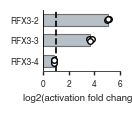

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(1, 0.8))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, xlim=(0, 6))
plt.savefig('../../figures/fig4/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


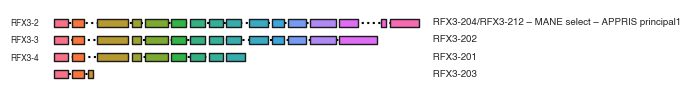

In [122]:
fig, ax = plt.subplots(figsize=(5, 1))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


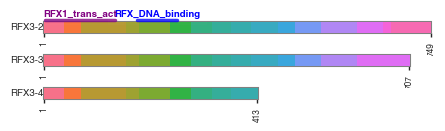

In [123]:
fig, ax = plt.subplots(figsize=(5, 1))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


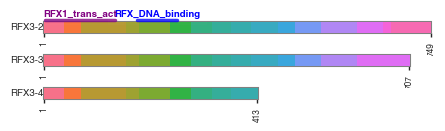

In [124]:
fig, ax = plt.subplots(figsize=(5, 1))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

### PBX1

In [125]:
gene_name = "PBX1"

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


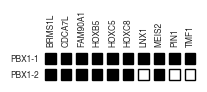

In [126]:
tf = tfs[gene_name]
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
y2h_ppi_per_tf_gene_plot(tf.name, ax=ax, data=y2h)
plt.savefig('../../figures/fig4/{}_y2h-profile.pdf'.format(gene_name), bbox_inches='tight')

In [127]:
cats_y2h[cats_y2h["gene_symbol_partner"].isin(["PIN1", "TMF1"])]

,gene_symbol_partner,category,cofactor_type
13,PIN1,TF,NaN
318,TMF1,TF,NaN


In [128]:
pairs[pairs["gene_symbol"] == "PBX1"]

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,n_positive_PPI_ref_other_HEK,n_positive_PPI_alt_other_HEK,n_PPI_successfully_tested_in_ref_and_alt_other_HEK,n_positive_PPI_ref_filtered_other_HEK,n_positive_PPI_alt_filtered_other_HEK,n_shared_PPI_other_HEK,n_PPI_diff_other_HEK,PPI_delta_n_other_HEK,PPI_jaccard_other_HEK,activation_abs_fold_change
20,PBX1,ENSG00000185630,Homeodomain,False,PBX1|1/2|02A05,PBX1|2/2|02C05,ENST00000420696,ENST00000367897,False,False,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.099522


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


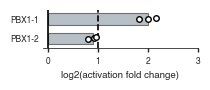

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(2, 0.5))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, xlim=(-0.1, 3))
plt.savefig('../../figures/fig4/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


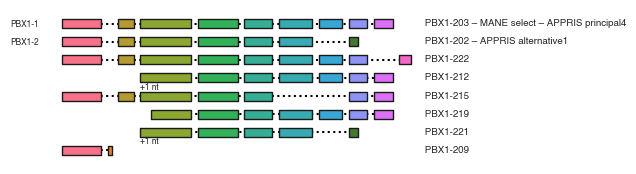

In [130]:
fig, ax = plt.subplots(figsize=(5, 2))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


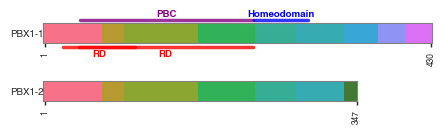

In [131]:
fig, ax = plt.subplots(figsize=(5, 1))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

### CREB5

In [132]:
gene_name = "CREB5"

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


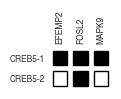

In [133]:
tf = tfs[gene_name]
fig, ax = plt.subplots(1, 1, figsize=(0.8, 0.8))
y2h_ppi_per_tf_gene_plot(tf.name, ax=ax, data=y2h)
plt.savefig('../../figures/fig4/{}_y2h-profile.pdf'.format(gene_name), bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


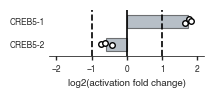

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(2, 0.6))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, xlim=(-2.2, 2.2))
plt.savefig('../../figures/fig4/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


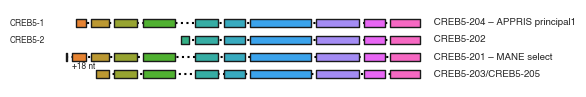

In [135]:
fig, ax = plt.subplots(figsize=(5, 1))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


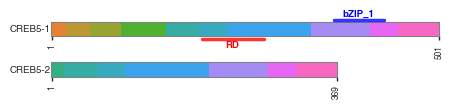

In [136]:
fig, ax = plt.subplots(figsize=(5, 0.7))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

In [137]:
tfs["CREB5"]["CREB5-204"].exons

[Exon of CREB5|1/3|08E11 54 nt,
 Exon of CREB5|1/3|08E11 94 nt,
 Exon of CREB5|1/3|08E11 122 nt,
 Exon of CREB5|1/3|08E11 173 nt,
 Exon of CREB5|1/3|08E11 127 nt,
 Exon of CREB5|1/3|08E11 111 nt,
 Exon of CREB5|1/3|08E11 324 nt,
 Exon of CREB5|1/3|08E11 228 nt,
 Exon of CREB5|1/3|08E11 109 nt,
 Exon of CREB5|1/3|08E11 161 nt]

In [138]:
tfs["CREB5"]["CREB5-202"]

Clone acc: CREB5|2/3|08A12
Isoform: CREB5-202 / ENSP00000379592 / ENST00000396298
length: 369 aa

### DLX1

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


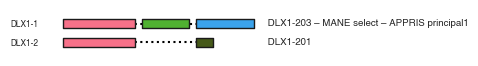

In [139]:
gene_name = "DLX1"
fig, ax = plt.subplots(figsize=(3, 0.6))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


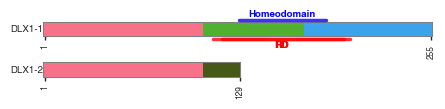

In [140]:
fig, ax = plt.subplots(figsize=(5, 0.7))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


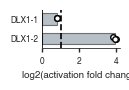

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(1, 0.5))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, xlim=(0, 4.2))
plt.savefig('../../figures/fig4/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')

### ATF2

In [142]:
gene_name = "ATF2"

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


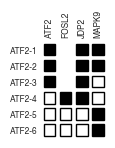

In [143]:
tf = tfs[gene_name]
fig, ax = plt.subplots(1, 1, figsize=(1.25, 1.25))
y2h_ppi_per_tf_gene_plot(tf.name, ax=ax, data=y2h)
plt.savefig('../../figures/fig4/{}_y2h-profile.pdf'.format(gene_name), bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


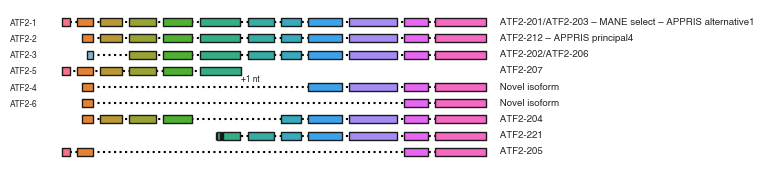

In [144]:
fig, ax = plt.subplots(figsize=(6, 2))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


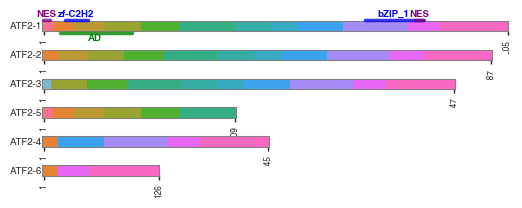

In [145]:
fig, ax = plt.subplots(figsize=(6, 2))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

### TBX5

In [146]:
gene_name = "TBX5"

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


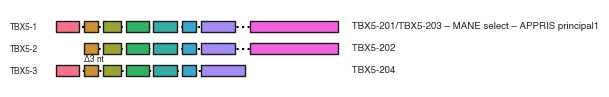

In [147]:
fig, ax = plt.subplots(figsize=(4, 1))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


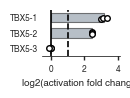

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(1, 0.6))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, xlim=(-0.5, 4.1))
plt.savefig('../../figures/fig4/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')

### TGIF1

In [149]:
gene_name = "TGIF1"

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


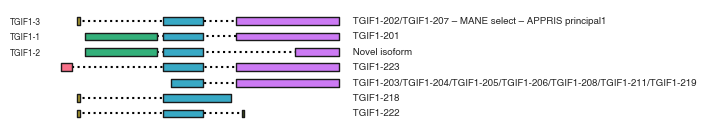

In [150]:
fig, ax = plt.subplots(figsize=(4, 1.5))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


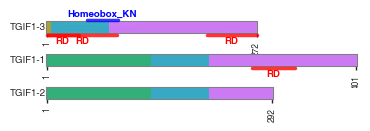

In [151]:
fig, ax = plt.subplots(figsize=(4, 1))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


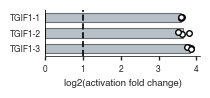

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(2, 0.6))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, xlim=(0, 4.1))
plt.savefig('../../figures/fig4/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')

### E2F3

In [153]:
gene_name = "E2F3"

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


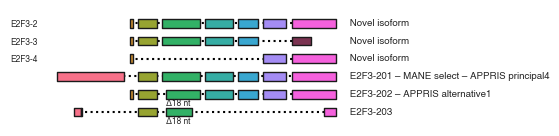

In [154]:
fig, ax = plt.subplots(figsize=(4, 1.5))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


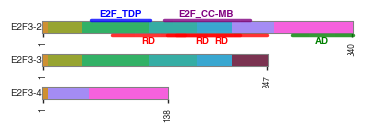

In [155]:
fig, ax = plt.subplots(figsize=(4, 1))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


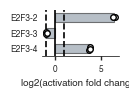

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(1, 0.6))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, xlim=(-1.5, 7))
plt.savefig('../../figures/fig4/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')

### FOXP3

In [157]:
gene_name = "FOXP3"

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


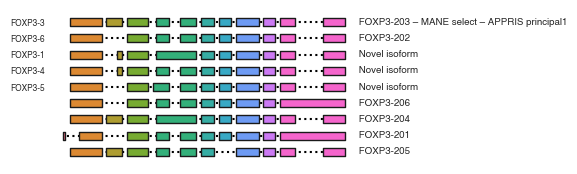

In [158]:
fig, ax = plt.subplots(figsize=(4, 2))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


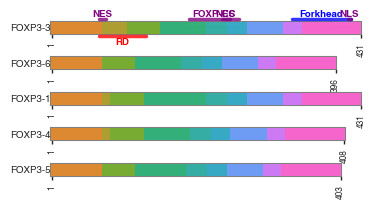

In [159]:
fig, ax = plt.subplots(figsize=(4, 2))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


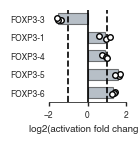

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(1, 1.2))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, xlim=(-2, 2), iso_order=["FOXP3-3", "FOXP3-1",
                                                                                          "FOXP3-4", "FOXP3-5",
                                                                                          "FOXP3-6"])
plt.savefig('../../figures/fig4/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')